In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2025-08-04 17:55:15.057971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754330115.273468      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754330115.332686      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection")
img_size = (224, 224)
batch_size = 32

In [3]:
filepaths, labels = [], []
for label in ["yes", "no"]:
    for file in os.listdir(dataset_path / label):
        filepaths.append(str(dataset_path / label / file))
        labels.append(label)
df = pd.DataFrame({"filepaths": filepaths, "label": labels})

In [4]:
print(df['label'].value_counts())

label
yes    155
no      98
Name: count, dtype: int64


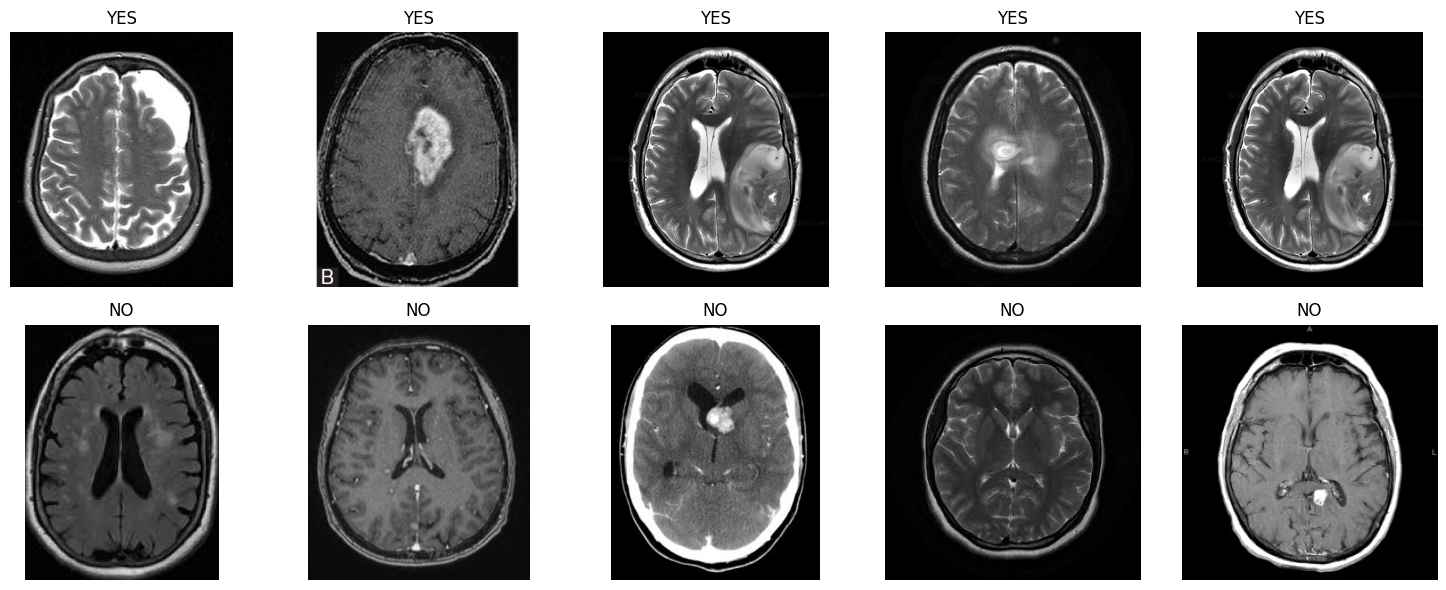

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, label in enumerate(["yes", "no"]):
    folder_path = dataset_path / label
    image_names = os.listdir(folder_path)[:5]
    
    for j, image_name in enumerate(image_names):
        img_path = folder_path / image_name
        img = Image.open(img_path)
        
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(label.upper())

plt.tight_layout()
plt.show()

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

In [7]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label',
    target_size=img_size, class_mode='binary', shuffle=True, batch_size=batch_size)

valid_gen = datagen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label',
    target_size=img_size, class_mode='binary', shuffle=False, batch_size=batch_size)

test_gen = datagen.flow_from_dataframe(test_df, x_col='filepaths', y_col='label',
    target_size=img_size, class_mode='binary', shuffle=False, batch_size=batch_size)

Found 181 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [8]:
input_layer = Input(shape=(224, 224, 3))

base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)
base_model.trainable = False  # Freeze the convolutional base

I0000 00:00:1754330130.001896      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754330130.002588      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
callbacks = [
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [12]:
model.fit(
    train_gen, 
    validation_data=valid_gen, 
    epochs=20, 
    callbacks=callbacks, 
    verbose=1
)

Epoch 1/20


I0000 00:00:1754330143.833076      65 service.cc:148] XLA service 0x7cb9bc002f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754330143.834454      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754330143.834481      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754330145.366349      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/6 ━━━━━━━━━━━━━━━━━━━━ 1:26 17s/step - accuracy: 0.4375 - loss: 1.0271

I0000 00:00:1754330150.738752      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.4978 - loss: 0.9623 - val_accuracy: 0.5238 - val_loss: 0.8458
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.5824 - loss: 0.7594 - val_accuracy: 0.5714 - val_loss: 0.7275
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.6308 - loss: 0.6540 - val_accuracy: 0.6190 - val_loss: 0.6427
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.8101 - loss: 0.4043 - val_accuracy: 0.7143 - val_loss: 0.5812
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.7631 - loss: 0.4333 - val_accuracy: 0.7143 - val_loss: 0.5360
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.8275 - loss: 0.3758 - val_accuracy: 0.7619 - val_loss: 0.5027
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.8818 - loss: 0.2583 - val_accuracy: 0.8095 - val_loss: 0.4725
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.8391 - loss: 0.3229 - val_accuracy: 0.8095 - val_loss: 0.4465
Epoch

In [13]:
model.save("Classification_model.keras")

In [14]:
model = load_model("best_model.h5")
loss, acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8235


In [15]:
y_pred = model.predict(test_gen).ravel()
y_true = test_gen.labels
y_pred_bin = (y_pred > 0.5).astype(int)

print(classification_report(y_true, y_pred_bin, target_names=["NO", "YES"]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
              precision    recall  f1-score   support

          NO       0.87      0.65      0.74        20
         YES       0.81      0.94      0.87        31

    accuracy                           0.82        51
   macro avg       0.84      0.79      0.80        51
weighted avg       0.83      0.82      0.82        51

